# PyTorch basics

В этой тетрадке мы познакомимся с общими принципами построения нейронных сетей.

**Цели тетрадки**

1. Знакомство с базовыми слоями PyTorch
1. Практика в построении и обучении сетей

**(повтор) Материалы по pytorch:**

* [PyTorch docs](https://pytorch.org/docs/stable/index.html)
* [Классная статья про pytorch internal](http://blog.ezyang.com/2019/05/pytorch-internals/)

## Prerequirements

```
pip install torch torchvision numpy matplotlib
```

In [92]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

## Hello MNIST

Прежде чем собирать сеть, давайте определим инстансы класса `Dataset`, которые будут возвращать примеры из тренировочной и валидационной выборок.  
С помощью ячейки ниже, мы скачаем датасет [MNIST](http://yann.lecun.com/exdb/mnist/) в текущую директорию и сможем получать примеры из соответствующих объектов.

In [93]:
transform_to_tensor = transforms.Compose([
    transforms.ToTensor()
])

mnist_train = MNIST(root='./', train=True, download=True, transform=transform_to_tensor)
mnist_val = MNIST(root='./', train=False, download=True, transform=transform_to_tensor)

Посмотрим на несколько примеров из тренировочной выборки

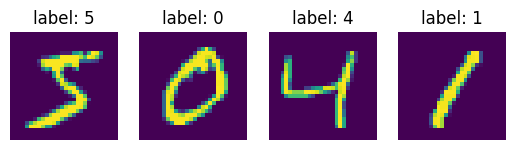

In [94]:
def show_examples(dataset: Dataset, num_examples: int = 4):
    fig, ax = plt.subplots(1, num_examples)

    for i in range(num_examples):
        img, label = dataset[i]
        ax[i].imshow(img[0])
        ax[i].set_title(f'label: {label}')
        ax[i].axis('off')
    plt.show()


show_examples(dataset=mnist_train)

## Задание 1
**(0.5 балла)** Напишите свою версию датасета, который будет читать картинки с диска.  
Подразумевается, что если вы написали свой датасет, то он будет использоваться при обучении вместо дефолтного `MNIST`.  

В ячейках ниже сгенерится датасет в таком формате:
- /MNIST_image_folder
    - /train.csv
    - /train/{class_name}/{image_name}.png
    - /val.csv
    - /val/{class_name}/{image_name}.png

CSV файлы содержат название файла и его лейбл: `image`, `label`.

*Hint 1:* нужно унаследоваться от класса `Dataset` и переопределить методы `__getitem__` и `__len__`.
Первый должен возвращать картинку и ее лейбл, а второй количество примеров в датасете.
(На самом деле второй метод не обязателен для самого датасета, но он необходим для
[семплера](https://pytorch.org/docs/stable/data.html#torch.utils.data.RandomSampler),
который используется даталоадером)
(см. [PyTorch docs](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset),
[PyTorch tutorual](https://pytorch.org/tutorials/recipes/recipes/custom_dataset_transforms_loader.html?highlight=dataset))  
*Hint 2:* для работы с картинками лучше использовать OpenCV: `pip install opencv-python-headless`.
В частности [cv2.imread](https://docs.opencv.org/master/d4/da8/group__imgcodecs.html#ga288b8b3da0892bd651fce07b3bbd3a56).  
*Hint 3:* обратите особое внимание на то, что возвращает функция `cv2.imread` (пример загрузки изображения с помощью cv2 есть в семе)


In [95]:
import pickle
import numpy as np
import os
import cv2
from collections import Counter
from tqdm.auto import tqdm
import pandas as pd

def generate_image_folder_dataset(dataset, target_path, csv_path):

    images_counter = Counter()

    files = []
    labels = []

    for image, label in tqdm(dataset):
        class_folder = target_path + "/" + str(label)
        if not os.path.exists(class_folder):
            os.makedirs(class_folder, exist_ok=True)

        images_counter[label] += 1
        file_name = f"/{images_counter[label]:05}.png"
        full_image_file_name = class_folder + file_name

        files.append(str(label) + file_name)
        labels.append(label)

        image = np.array(image)
        image = (image * 255).astype(np.uint8)
        image = np.transpose(image, [1, 2, 0])
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

        # print(image.dtype)
        # print(image.shape)
        cv2.imwrite(full_image_file_name, image)

        # break
    pd.DataFrame({ "image": files, "label": labels }).to_csv(csv_path, index=False)

generate_image_folder_dataset( mnist_train,  "./MNIST_image_folder/train", "MNIST_image_folder/train.csv" )
generate_image_folder_dataset( mnist_val,  "./MNIST_image_folder/val", "MNIST_image_folder/val.csv" )

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Теперь можно написать свой класс датасета для тех файлов, которые мы сгенерили

In [97]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import cv2
import os

class DatasetMNIST(Dataset):
    def __init__(self, root='./MNIST_image_folder', train=True, transform=None):
        self.root = root
        self.transform = transform
        self.train = train

        if self.train:
            self.csv_path = os.path.join(self.root, 'train.csv')
            self.image_folder = os.path.join(self.root, 'train')
        else:
            self.csv_path = os.path.join(self.root, 'val.csv')
            self.image_folder = os.path.join(self.root, 'val')

        self.data = pd.read_csv(self.csv_path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_path = os.path.join(self.image_folder, self.data.iloc[index, 0])
        label = self.data.iloc[index, 1]
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if self.transform:
            image = self.transform(image)
        return {'image': image, 'label': label}

тест класса датасета

In [98]:
def test_dataset(dataset, test_name=""):

    assert len(dataset) > 0, f"{test_name}: dataset length is greater then zero"

    idateset = iter(dataset)
    item = next(idateset)

    assert isinstance(item, dict), f"{test_name}: dataset returned dict"
    assert "image" in item, f"{test_name}: dataset item dict has image"
    assert "label" in item, f"{test_name}: dataset item dict has label"

    assert item['image'].shape == (1, 28, 28), f"{test_name}: dataset image shape is correct. Got: {item['image'].shape}"

mydataset = DatasetMNIST(train=False, transform=transform_to_tensor)
test_dataset(mydataset, test_name="val")

mydataset = DatasetMNIST(train=True, transform=transform_to_tensor)
test_dataset(mydataset, test_name="train")

## Задание 2
**(0.3 балла)** Напишите класс MLP сети из 3 линейных слоев, которая будет получать на вход
батч картинок размера [BS, C, H, W]

*Hint 1:* метод `.flatten(start_dim=1)` поможет вытянуть картинку в вектор.  
*Hint 2:* выход должен соответствовать количеству лейблов, то есть 10.  
*Hint 3:* пачка линейных слоев подряд не имеет смысла без нелинейностей между ними. Попробуйте разные слои нелинейности (один слой на один эксперимент): `ReLU`, `LeakyReLU`, `Tanh` ... [Другие](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)

In [117]:
# важно! все зависимости, которые используете (если добавляее новые) в этом классе надо явно продублировать в эту ячейку
import torch
import torch.nn as nn
import torch.nn.functional as F
class CustomMLP(nn.Module):
    def __init__(self,
                 num_pixels_per_img: int = 784,  # hint: 28*28 == 784
                 ):
        super().__init__()

        self.inner = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(num_pixels_per_img, 512),
            nn.BatchNorm1d(512),
            nn.Tanh(),
            nn.Linear(512, 256),
            nn.Tanh(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = x.reshape((x.shape[0], -1))

        return self.inner(x)

    def compute_all(self, batch):  # удобно сделать функцию, в которой вычисляется лосс по пришедшему батчу
        x = batch['image']
        y = batch['label']
        logits = self.inner(x)

        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(axis=1) == y).float().mean().cpu().numpy()
        metrics = dict(acc=acc)
        return loss, metrics

## Задание 3
**(0.3 балла)** Напишите класс CNN сети из 3 сверточных слоев.

*Hint 1:* на вход все те же батчи размера [BS, C, H, W]  
*Hint 2:* описание сверточных слоев [PyTorch docs](https://pytorch.org/docs/stable/nn.html#convolution-layers). Нам нужен `Conv2d`

Тут тоже можете поэксперементировать с разными слоями активации.

Чтобы было проще считать размерности для конечного слоя, используйте `kernel_size=3, padding=1` в сверточных слоях

In [118]:
# важно! все зависимости, которые используете (если добавляее новые) в этом классе надо явно продублировать в эту ячейку
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)  # 1 канал для MNIST
        self.act1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()

        self.fc = nn.Linear(64 * 28 * 28, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.conv3(x)
        x = self.act3(x)
        x = x.view(x.size(0), -1)  # Вытягиваем в вектор
        x = self.fc(x)
        return x

    def compute_all(self, batch):
        images = batch['image']
        labels = batch['label']

        outputs = self.forward(images)

        criterion = nn.CrossEntropyLoss()
        loss = criterion(outputs, labels)
        return loss, {'logits': outputs}

## Задание 4
**(0.3 балла)** Напишите класс CNN сети из 3 блоков с добавлением skip-connection блока
(ResNet [paper](https://arxiv.org/abs/1512.03385)).  
**(0.3 балла)** Реализовать residual блок в отдельном классе `ResBlock`.

*Hint 1:* на вход все те же батчи размера [BS, C, H, W]  
*Hint 2:* пример skip-connection:  
![image](https://i1.wp.com/dangminhthang.com/wp-content/uploads/2020/06/resnet-block.jpg?fit=400%2C225)

In [119]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResBlock(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()

        # Первый сверточный слой
        self.conv1 = nn.Conv2d(in_channels=in_dim, out_channels=hidden_dim, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(hidden_dim)
        self.act1 = nn.ReLU()

        # Второй сверточный слой
        self.conv2 = nn.Conv2d(in_channels=hidden_dim, out_channels=in_dim, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(in_dim)
        self.act2 = nn.ReLU()

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.act1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.act2(out)

        return out

class CustomResNet(nn.Module):
    def __init__(self, in_channels: int = 1, num_classes: int = 10):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.res_block1 = ResBlock(in_dim=16, hidden_dim=16)
        self.res_block2 = ResBlock(in_dim=16, hidden_dim=32)
        self.res_block3 = ResBlock(in_dim=16, hidden_dim=64)

        self.fc = nn.Linear(16 * 14 * 14, num_classes)

    def forward(self, x):
        # Применяем первый сверточный слой
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.pool1(x)

        # Применяем residual блоки
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def compute_all(self, batch):
        images = batch['image']
        labels = batch['label']

        outputs = self.forward(images)

        criterion = nn.CrossEntropyLoss()
        loss = criterion(outputs, labels)

        acc = (outputs.argmax(axis=1) == labels).float().mean().cpu().numpy()
        metrics = dict(acc=acc)

        return loss, metrics

## Задание 5
**(0.3 балла)** Инициализируйте и обучите сети из пунктов 1, 2, 3, используя класс `Trainer` из семинара.

В тренерене, возможно, вы захотите писать больше метрик: лосс во время трейна, валидационный лосс, валидационные метрики (можно префиксовать валидационные метрики с помощью "val", чтобы не путались)

Каждая модель должна побить определенные пороги кач-ва (> 0.8 за 3 эпохи)

In [120]:
from torch.utils.tensorboard import SummaryWriter

class Trainer:
    def __init__(self, model, optimizer, train_dataset, val_dataset, batch_size=128):
        # pass
        self.model = model
        self.optimizer = optimizer
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.batch_size = batch_size

        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = self.model.to(self.device)

        self.global_step = 0

    def save_checkpoint(self, path):
        torch.save(self.model.state_dict(), path)

    def train(self, num_epochs: int):
        model = self.model
        optimizer = self.optimizer

        train_loader = DataLoader(self.train_dataset, shuffle=True, pin_memory=True, batch_size=self.batch_size)
        val_loader = DataLoader(self.val_dataset, shuffle=False, pin_memory=True, batch_size=self.batch_size)
        best_loss = float('inf')

        for epoch in range(num_epochs):
            model.train()
            for batch in tqdm(train_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                self.global_step += 1

            with torch.no_grad():
                model.eval()
                val_losses = []
                for batch in tqdm(val_loader):
                    batch = {k: v.to(self.device) for k, v in batch.items()}
                    loss, details = model.compute_all(batch)
                    val_losses.append(loss.item())

                val_loss = np.mean(val_losses)

                if val_loss < best_loss:
                    self.save_checkpoint("./best_checkpoint.pth")
                    best_loss = val_loss

#### CustomMLP

In [106]:
model = CustomMLP()
opt = optim.SGD(model.parameters(), lr=3e-3)

mnist_train = DatasetMNIST(train=True, transform=transform_to_tensor)
mnist_val = DatasetMNIST(train=False, transform=transform_to_tensor)

trainer = Trainer(model, opt, mnist_train, mnist_val, batch_size=128)

In [107]:
trainer.train(3)
torch.save(model.state_dict(), "custom_mlp.pt") # важно сохранить веса обученой модели!

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

#### CustomCNN

In [108]:
model = CustomCNN()
opt = optim.SGD(model.parameters(), lr=3e-3)

mnist_train = DatasetMNIST(train=True, transform=transform_to_tensor)
mnist_val = DatasetMNIST(train=False, transform=transform_to_tensor)

trainer = Trainer(model, opt, mnist_train, mnist_val, batch_size=128)

In [109]:
trainer.train(3)
torch.save(model.state_dict(), "custom_cnn.pt")  # важно сохранить веса обученой модели!

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

#### CustomResNet

In [113]:
model = CustomResNet()
opt = optim.SGD(model.parameters(), lr=3e-3)

mnist_train = DatasetMNIST(train=True, transform=transform_to_tensor)
mnist_val = DatasetMNIST(train=False, transform=transform_to_tensor)

trainer = Trainer(model, opt, mnist_train, mnist_val, batch_size=128)

In [114]:
trainer.train(3)
torch.save(model.state_dict(), "custom_resnet.pt") # важно сохранить веса обученой модели!

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

### Тест


In [115]:
import pytest
import torch
import torch.nn as nn

import sys

from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST

transform_to_tensor = transforms.Compose([
    transforms.ToTensor()
])

mnist_val = MNIST(root='./', train=False, download=True, transform=transform_to_tensor)

def _test_model(model, target_accuracy, flatten=True):
    print(model)

    dataloader = DataLoader(mnist_val, batch_size=128)

    all_logits = []
    all_labels = []

    with torch.no_grad():

        for images, labels in dataloader:
            if flatten:
                images = images.flatten(1)
            logits = model(images)
            all_logits.append(logits)
            all_labels.append(labels)

        all_logits = torch.cat(all_logits)
        all_labels = torch.cat(all_labels)

        print(all_logits.shape, all_labels.shape)

        accuracy = (all_logits.argmax(axis=1) == all_labels).float().mean().cpu().numpy()
        print("accuracy", accuracy)

        assert accuracy > target_accuracy

def test_model_mlp():

    cmlp = CustomMLP()
    cmlp.load_state_dict( torch.load("custom_mlp.pt") )
    cmlp.eval()

    _test_model(cmlp, 0.8, flatten=True)

def test_model_cnn():

    ccnn = CustomCNN()
    ccnn.load_state_dict( torch.load("custom_cnn.pt") )
    ccnn.eval()

    _test_model(ccnn, 0.8, flatten=False)


def test_model_resnet():

    cresnet = CustomResNet()
    cresnet.load_state_dict( torch.load("custom_resnet.pt") )
    cresnet.eval()

    _test_model(cresnet, 0.8, flatten=False)



test_model_mlp()
test_model_cnn()
test_model_resnet()

<ipython-input-115-cf244f19bd01>:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cmlp.load_state_dict( torch.load("custom_mlp.pt") )


CustomMLP(
  (inner): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Tanh()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): Tanh()
    (6): Linear(in_features=256, out_features=10, bias=True)
  )
)
torch.Size([10000, 10]) torch.Size([10000])
accuracy 0.8945
CustomCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (fc): Linear(in_features=50176, out_features=10, bias=True)
)


<ipython-input-115-cf244f19bd01>:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ccnn.load_state_dict( torch.load("custom_cnn.pt") )


torch.Size([10000, 10]) torch.Size([10000])
accuracy 0.9134
CustomResNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (res_block1): ResBlock(
    (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU()
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): ReLU()
  )
  (res_block2): ResBlock(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU()
    (conv2): Conv2d(32, 16, kernel_

<ipython-input-115-cf244f19bd01>:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cresnet.load_state_dict( torch.load("custom_resnet.pt") )


torch.Size([10000, 10]) torch.Size([10000])
accuracy 0.9802


#### Не забываем смотреть графички в wandb